# N-Tuple Learning 6

In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.cm as cm
import ipywidgets as widgets
from ipyevents import Event
import time
import gymnasium as gym
import torch
import torch.nn as nn
from typing import Any, cast
from collections import deque
import random
import cv2
from IPython.display import HTML
from matplotlib.patches import FancyArrow
import pickle

In [2]:
sys.path.insert(1, str(Path("../..")))
from andreas2048.game import *
from andreas2048 import gym2048
env = gym2048.Env2048()

In [3]:
raise RuntimeError("STOP")

RuntimeError: STOP

In [ ]:
class StateEstimator(nn.Module):
    """ 
        Implementation of State Aproximator for a 2048 grid.
    """

    def __init__(self, grid_shape: tuple[int, int], device: str) -> None:
        super().__init__()
        self.device = device
        assert grid_shape == (4,4)
        self.n_features = 7
        self.powers = torch.tensor([18**3, 18**2, 18, 1]).view(1,1,1,4).to(self.device)

        self.ttables = nn.Embedding(num_embeddings=18**4, embedding_dim=4*self.n_features).to(self.device)
        with torch.no_grad():
            self.ttables.weight.fill_(20_000.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Expects tensor of shape (n,14,4,4) """
        x = (x[:, :, :, :] * self.powers).sum(dim=-1) # (n,14,4,4) -> (n,14,4)
        x = self.ttables.forward(x) # (n,14,4) -> (n,14,4,56)
        x = x.flatten(start_dim=1, end_dim=-2) # (n,14,4,56) -> (n, 56, 56)
        x = x.diagonal(dim1=-2, dim2=-1).reshape(-1, self.n_features, 4) # (n,56,56) -> # (n, 56) -> (n,14,4)
        return x # (n,14,4)
    
    def count_unvisited_states(self, x: np.ndarray) -> int:
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,14,4,4)
        t = torch.from_numpy(x).to(self.device)
        vs = self.forward(t)
        return int(torch.count_nonzero(vs == self.ttables.weight[18**4-1][0]).item())
    
    def V_raw(self, x: np.ndarray) -> torch.Tensor:
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,14,4,4)
        t = torch.from_numpy(x).to(self.device)
        vs = torch.mean(self.forward(t), dim=(1,2)) 
        return vs

    def V(self, x: np.ndarray) -> np.ndarray:
        """ 
        Outputs the value function estimation by the model

        Args:
            x (np.ndarray): n-boards of shape (n,4,4) 

        Returns:
            V (np.ndarray): The value of the n-boards encoded as numpy array with shape (n,)
        
        """
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,14,4,4)
        t = torch.from_numpy(x).to(self.device)
        with torch.no_grad():
            vs = torch.mean(self.forward(t), dim=(1,2)) 
        return vs.detach().numpy()
    

    def extract_tuples(self, grid: np.ndarray) -> np.ndarray:
        """
        Extract the n-tuples from n boards of shape (n, 4, 4). Returns the tuples as a numpy array of shape \n
        (n, |n_tuple|, 4, 4, 3) = (n, 14, 4, 3, 4) \n
        with the third value representing the rotation (Top, Right, Bottom, Left). The fourth values represents
        the current n-Tuple (index 0), the tuple prediction to the right (index 1) and left (index 2).
        The last values the ith value inside the n-tuple.
        """
        assert len(grid.shape) >= 3 and grid.shape[1] == 4 and grid.shape[2] == 4
        n_tuples = np.zeros(shape=(grid.shape[0],self.n_features,4,4), dtype=grid.dtype)
        for k in range(4):
            g_v = np.rot90(grid, k=k, axes=(1,2))
            n_tuples[:,0,k] = g_v[:,0,::-1] # Outer
            n_tuples[:,1,k] = g_v[:,1,:: 1] # Inner
            n_tuples[:,2,k] = g_v[:, [1,1,0,0], [-2,-1,-1,-2]] # Edge
            n_tuples[:,3,k] = g_v[:, [1,1,0,0], [-3,-2,-2,-3]] # Inner Edge
            # n_tuples[:,4,k] = g_v[:, [2,1,1,0], [0,0,1,1]] # Left Z
            # n_tuples[:,5,k] = g_v[:, [2,1,1,0], [1,1,2,2]] # Middle Z
            # n_tuples[:,6,k] = g_v[:, [2,1,1,0], [2,2,3,3]] # Right Z
            # n_tuples[:,7,k] = g_v[:, [2,1,1,0], [1,1,0,0]] # Left Mirror Z
            # n_tuples[:,8,k] = g_v[:, [2,1,1,0], [2,2,1,1]] # Middle Mirror Z
            # n_tuples[:,9,k] = g_v[:, [2,1,1,0], [3,3,2,2]] # Right Mirror Z
            # n_tuples[:,10,k] = g_v[:, [2,1,0,0], [1,1,1,0]] # Left Arrow
            # n_tuples[:,11,k] = g_v[:, [2,1,0,0], [2,2,2,1]] # Middle Arrow
            # n_tuples[:,12,k] = g_v[:, [2,1,0,0], [3,3,3,2]] # Right Arrow
            # n_tuples[:,13,k] = g_v[:, [1,0,0,0], [2,2,1,0]] # Edge Arrow

        return n_tuples
    
# Testing the implementation
net = StateEstimator(grid_shape=env.game.shape, device="cpu")
print("Shape of extracted tuple (expect (n,n_features,4,4)):",net.extract_tuples(env.game.grid[None, :]).shape)
print("Full network output (expect a, a, b):", net.V(np.array([env.game.grid, env.game.grid, np.rot90(env.game.grid)])))
print("Unvisited states count:", net.count_unvisited_states(np.array([env.game.grid, env.game.grid])))

Shape of extracted tuple (expect (n,n_features,4,4)): (1, 7, 4, 4)
Full network output (expect a, a, b): [1000. 1000. 1000.]
Unvisited states count: 56


In [5]:
class Agent:
    """ Implements an agent for 2048 """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.05, 
                gamma: float = 0.99,
                epsilon: float = 1.0,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.env.reset()
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = StateEstimator(grid_shape=env.game.grid.shape, device=self.device)
        
        # Learning parameters
        self._lr = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.warm_start_tiles = [1,2,3,4,5,6,7,8,9,10,11,12]
        self.warm_start_p = [20,10,5,5,4,3,1,1,1,1,1,1]
        self.warm_start_n = 3

        self.episode = 0
        self.batch_size: int = 500
        self.history: list[Game] = []
        self.losses: dict[int, float] = {}
        self.V_ranges: dict[int, tuple[tuple[float, float], tuple[float, float]]] = {}
        self.unvisited_states_count: dict[int, float] = {}

        self.init()

    def init(self):
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self._lr)
        self.replay_buffer: deque[tuple[State, float]] = deque(maxlen=2_000)

    def remember(self) -> None:
        for s in self.env.game.history:
            if s.parent is not None:
                s.parent.backtrace_reward(s.reward, lambda_=0.99, adjust=True) # Transform reward to discounted return Gt with half time t=60
        self.replay_buffer.extend([(s, s.reward) for s in self.env.game.history[1:]]) 
        self.history.append(env.game)

    def reset(self, warm_start: bool = False) -> None:
        self.env.reset()
        if warm_start:
            self.env.game.state.warm_start(tiles=self.warm_start_tiles, p=self.warm_start_p, n=self.warm_start_n)

    def update(self) -> None:
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.choices(self.replay_buffer, k=self.batch_size)
        states, reward = cast(tuple[list[State], list[float]], zip(*batch))

        # states = self.history[-1].history[1:]
        # reward = [s.reward for s in states]

        grids = np.array([s.parent.grid for s in states]) # s_n
        next_grid = np.array([s.grid for s in states]) # s_n+1
        rewards = np.array([r for r in reward]) # (Discounted) reward from s_n to s_n+1
        rewards = torch.from_numpy(rewards).float().to(self.device)

        vn_estimated = self.model.V_raw(grids)
        with torch.no_grad():
            vn_actually = rewards + self.gamma*(self.model.V_raw(next_grid))

        v1 = vn_estimated.detach().numpy()
        v2 = vn_actually.detach().numpy()
        self.V_ranges[self.episode] = ((np.min(v1), np.max(v1)), (np.min(v2), np.max(v2)))
        self.unvisited_states_count[self.episode] = self.model.count_unvisited_states(grids)

        loss: torch.Tensor = nn.L1Loss()(vn_estimated, vn_actually)
        self.losses[self.episode] = float(loss.detach().numpy())
        self.optimizer.zero_grad()
        loss.backward()
        self.model.ttables.weight.grad *= loss*len(states)
        self.optimizer.step()

    def step(self) -> bool:   
        next_state, reward, done, truncated, info = env.step(self.predict(greedy=False))
        return not(done or truncated)
    
    def predict(self, greedy: bool = True) -> Action:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if not greedy and np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        actions = self.get_qv(state=self.env.game.state, depth=0, sample_size=[10])
        return max(actions, key=actions.get)
    
    def get_qv(self, state: State, depth: int = 0, sample_size: list[int]|None = None) -> dict[Action, float]:
        qvs = {}
        for a in Action:
            next_states = state.get_next_states(a)
            if len(next_states) == 1 and list(next_states.keys())[0] == state:
                continue
            if sample_size is not None and sample_size[0] != -1:
                next_states = random.choices(list(next_states.items()), k=min(sample_size[0], len(next_states)), weights=list(next_states.values()))
                next_states = dict(next_states)
            next_states_grid = np.array([s.grid for s in next_states.keys()])   
            if depth <= 0:
                vs = self.model.V(next_states_grid) + [s.reward for s in next_states.keys()]
                qvs[a] = np.sum([p*v for p, v in zip(next_states.values(), vs)])
            else:
                vs = []
                for next_state in next_states.keys():
                    vs_ns = self.get_qv(state=next_state, depth=(depth-1), sample_size=(sample_size[1:] if sample_size is not None else None))
                    if len(vs_ns) == 0:
                        continue
                    vs.append(max(vs_ns.values()))
                if len(vs) == 0:
                    vs = self.model.V(next_states_grid) + [s.reward for s in next_states.keys()]
                qvs[a] = np.mean(vs)
        return qvs
    
    @property
    def scores(self) -> list[float]:
        return [g.score for g in self.history]
    
    @property
    def highest_tiles(self) -> list[int]:
        return [g.highest_tile for g in self.history]
    
    @property
    def move_counts(self) -> list[int]:
        return [g.move_count for g in self.history] 
    
    @property
    def loss(self) -> float|None:
        if len(self.losses) == 0:
            return None
        return self.losses[list(self.losses.keys())[-1]]
    
    @property
    def V_range(self) -> tuple[tuple[float, float], tuple[float, float]]|None:
        if len(self.V_ranges) == 0:
            return None
        return self.V_ranges[list(self.V_ranges.keys())[-1]]
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))

    def save(self, path: Path):
        p1 = path.parent / f"{path.name}.agent.dump"
        p2 = path.parent / f"{path.name}.history.dump"
        p3 = path.parent / f"{path.name}.model.dump"
        if p1.exists() or p2.exists() or p3.exists():
            raise FileExistsError("Can't save if the file already exists")
        with open(p1, "wb") as f:
            pickle.dump(self, f)
        with open(p2, "wb") as f:
            pickle.dump(self.history[-200:], f)
        torch.save(self.model.state_dict(), p3)

    @staticmethod
    def load(path: Path) -> Self:
        p1 = path.parent / f"{path.name}.agent.dump"
        if not p1.exists():
            raise FileNotFoundError(f"File {p1.name} does not exist")
        with open(p1, "rb") as f:
            agent: Agent = pickle.load(f)
        agent.load_into(path)
        agent.env = env
        agent.init()
        return agent

    def load_into(self, path:Path) -> None:
        p2 = path.parent / f"{path.name}.history.dump"
        p3 = path.parent / f"{path.name}.model.dump"
        if not p2.exists():
            raise FileNotFoundError(f"File {p2.name} does not exist")
        if not p3.exists():
            raise FileNotFoundError(f"File {p3.name} does not exist")
        with open(p2, "rb") as f:
            self.history = pickle.load(f)
        self.model.load_state_dict(torch.load(p3))
        self.model.eval()

    def __getstate__(self) -> object:
        state = self.__dict__.copy()
        dels = ["env", "model", "optimizer", "history", "replay_buffer"]
        for d in dels:
            if d in state:
                del state[d]
        return state
    
    def __setstate__(self, state):
        self.__dict__.update(state)

agent = Agent(env=env, gamma=0.99, learning_rate=0.01, epsilon=0, epsilon_decay=0, epsilon_min=0)

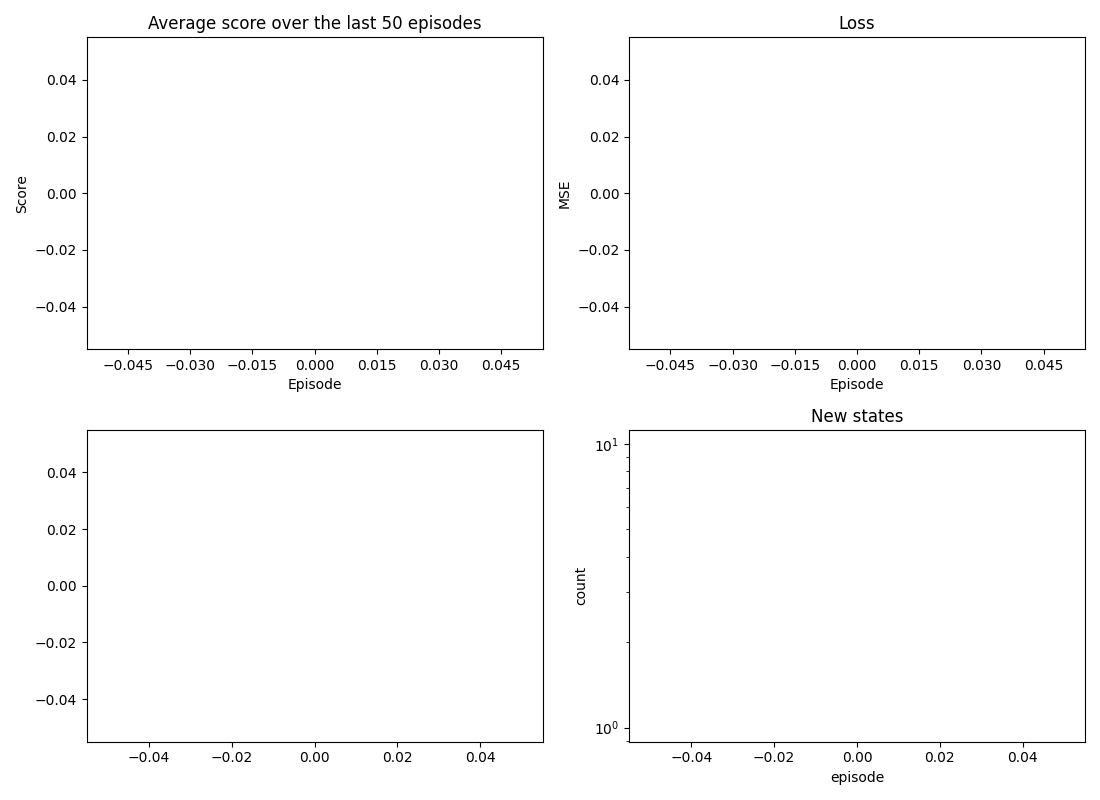

In [6]:
# Live plotting the training progress
%matplotlib widget
plt.ion()  # Interaktiver Modus an
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11,8))

ax1 = axes[0,0]
ax1.set_xlabel("Episode")
ax1.set_ylabel("Score")
ax1.set_title("Average score over the last 50 episodes")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
p1 = ax1.plot([], label="Scores")

ax2 = axes[0,1]
ax2.set_title("Loss")
ax2.set_xlabel("Episode")
ax2.set_ylabel("MSE")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
p2 = ax2.plot([])


ax3 = axes[1,0]
ax3.set_title("Tile distribution")
ax3.set_xlabel("Episode")
ax3.set_ylabel("%")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

ax4 = axes[1,1]
ax4.set_title("New states")
ax4.set_ylabel("count")
ax4.set_xlabel("episode")
ax4.set_yscale("log")
p4 = ax4.plot([])

fig.tight_layout()

def update_plot(agent:Agent, tiles: bool = False):
    scores = agent.scores
    if len(agent.losses) > 0 and max(agent.losses) > 0:
        ax2.set_yscale("log")
        p2[0].set_data(list(agent.losses.keys()), list(agent.losses.values()))
    else:
        ax2.set_yscale("linear")
        p2[0].set_data([], [])

    if len(agent.unvisited_states_count) > 0:
        p4[0].set_data(list(agent.unvisited_states_count.keys()), list(agent.unvisited_states_count.values()))
    else:
        p4[0].set_data([], [])
        
    if len(agent.history) == 0:
        p1[0].set_data([], [])
        ax3.clear()
    else:
        if tiles:
            d = []
            for i in range((len(agent.history) - 1)//100+1):
                highest_tiles = np.array([g.highest_tile for g in agent.history[100*i:100*(i+1)]])
                stack = np.array([np.count_nonzero(highest_tiles == 2**i) for i in range(3,14)])
                d.append(stack)
            d = np.array(d)
            d = d.T
            ax3.clear()
            if len(d) > 0:
                ax3.stackplot([100*i for i in range(d.shape[1])], d, labels=[f"{2**i}" for i in range(3,14)], colors=cm.Paired.colors)
                ax3.legend()

        p1[0].set_data(range(1,1+len(m := [np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores)+1)])), m)
        
    for ax in axes.flatten():
        ax.relim()
        ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()

update_plot(agent, tiles=True)

In [ ]:
agent.optimizer.param_groups[0]["lr"] = 0.2

In [ ]:
episode_cap = 100_000
warm_start = False
torch.set_grad_enabled(True)
try:
    for episode in range(agent.episode, episode_cap):
        agent.reset(warm_start=warm_start)
        while env.game.alive:
            done = agent.step()
        agent.remember()
        agent.update()
        agent.decay_epsilon()

        s = f"Episode {episode+1:>4}/{episode_cap}"
        for v in [
            f"Score: {env.game.score:5}", 
            f"Highest tile: {env.game.highest_tile:4}",
            f"Length: {env.game.move_count:3}",
            f"Epsilon: {agent.epsilon:1.3f}",
            f"Average rolling score: {np.mean(agent.scores[max(0,episode-50):]):10.3f}",
            f"Loss: {agent.loss:7.5f}" if agent.loss is not None else "",
            f"V: [{agent.V_range[0][0]:7.1f}, {agent.V_range[0][1]:7.1f}]" if agent.V_range is not None else "",
        ]:
            s += f" - {v}"
        print(s)

        if episode % 10 == 0:
            update_plot(agent, tiles=(episode%25 == 0))
        agent.episode = episode
    agent.episode += 1

except KeyboardInterrupt:
    pass
update_plot(agent)

Episode  134/100000 - Score:  1440 - Highest tile:  128 - Length: 150 - Epsilon: 0.000 - Average rolling score:   1274.923 - Loss: 8.03773 - V: [  999.4,  1000.4]
Episode  135/100000 - Score:  1352 - Highest tile:  128 - Length: 140 - Epsilon: 0.000 - Average rolling score:   1255.077 - Loss: 8.95840 - V: [  999.3,  1000.3]
Episode  136/100000 - Score:  1644 - Highest tile:  128 - Length: 160 - Epsilon: 0.000 - Average rolling score:   1278.077 - Loss: 9.61929 - V: [  999.3,  1000.3]
Episode  137/100000 - Score:   632 - Highest tile:   64 - Length:  88 - Epsilon: 0.000 - Average rolling score:   1263.308 - Loss: 10.03665 - V: [  999.2,  1000.2]
Episode  138/100000 - Score:   676 - Highest tile:   64 - Length:  88 - Epsilon: 0.000 - Average rolling score:   1228.692 - Loss: 9.29858 - V: [  999.0,  1000.1]
Episode  139/100000 - Score:  1152 - Highest tile:  128 - Length: 125 - Epsilon: 0.000 - Average rolling score:   1226.615 - Loss: 7.76462 - V: [  998.9,  1000.0]
Episode  140/100000 -

In [ ]:
w = agent.model.ttables.weight.detach().numpy()
print(np.max(w), np.min(w))

In [ ]:
agent.reset()

while agent.env.game.alive:
    a = agent.predict(greedy=True)
    agent.env.step(a)

g = agent.env.game.render_game(state_func=lambda s: f"agents expectes reward {agent.model.V(s.grid)[0]:1.0f} and final score {s.score + agent.model.V(s.grid)[0]:1.0f}")
html = g.to_jshtml()
plt.close()
HTML(html)

#